In [6]:
"""
Extracting the heatmap result separately here
to revisit with the group

This could perhaps be put in the appendix
"""

'\nExtracting the heatmap result separately here\nto revisit with the group\n\nThis could perhaps be put in the appendix\n'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
survey_file = '../../db-processing/survey_responses.tsv'
survey = pd.read_csv(survey_file, sep='\t')

codes_file = '../../db-processing/ad_codes.tsv'
codes = pd.read_csv(codes_file, sep='\t')
adid_codes = dict(zip(codes['adid'], [r.split(';') for r in codes['codes']]))

pid_adid_files = [f'../../db-processing/surveys/survey-{n}/survey{n}_coding_subsample.tsv'
                 for n in range(1, 8)]
pid_adid_files.append('../../db-processing/surveys/survey-1/pid_adid_survey1_batch2.tsv')
pid_adid = pd.read_csv(pid_adid_files[0], sep='\t')
for f in pid_adid_files[1:]:
    pid_adid = pd.concat([pid_adid, pd.read_csv(f, sep='\t')], ignore_index=True)

print('pid_adid:', pid_adid.shape)
print('survey:', survey.shape)
    
part_ad_counts = pid_adid.groupby('pid').count().to_dict()['adid']

pid_adid: (39564, 2)
survey: (7833, 5)


### Build Heatmap

In [8]:
short_names = {
    # dislike
    "I do not dislike this ad.": "dont-dislike",
    "I cannot tell what is being advertised.": "unclear",
    "It is irrelevant to me, or doesn’t contain interesting information.": "irrelevant",
    "I find the ad pushy or it causes me to feel anxious.": "pushy",
    "It contains clickbait, sensationalized, or shocking content.": "clickbait",
    "I do not trust this ad, it seems like a scam.": "scam",
    "I dislike the type of product being advertised.": "dislike-product",
    "I do not like the design of the ad.": "dislike-design",
    "I find the content uncomfortable, offensive, or repulsive.": "uncomfortable",    
    "I dislike the advertiser.": "dislike-advertiser",
    "I dislike the political nature of the ad.": "political",
    # like
    "The content is engaging, clever or amusing.": "amusing",
    "It is well designed or eye-catching.": "like-design",
    "I am interested in what is being advertised.": "interested",
    "It is clear what product the ad is selling.": "clear",
    "I trust the ad, it looks authentic or trustworthy.": "trust-ad",
    "I trust the advertiser.": "trust-advertiser",
    "It is useful, interesting, or informative.": "useful",
    "It clearly looks like an ad and can be filtered out.": "filterable",
    "I do not like this ad.": "dont-like"
}

like_list = ["amusing", "like-design", "interested", "clear", "trust-ad",
     "trust-advertiser", "useful", "filterable", "dont-like"]
dislike_list = ["dont-dislike", "unclear", "irrelevant", "pushy", "clickbait",
    "scam", "dislike-product", "dislike-design", "uncomfortable",
    "dislike-advertiser", "political"]

# actual reasons for liking or disliking
like_reasons = set(like_list) - set(["dont-like"])
dislike_reasons = set(dislike_list) - set(["dont-dislike"])

In [9]:
survey_codes = survey.merge(codes, 'inner', 'adid')

perceptions = defaultdict(list)  # perceptions by code
survey_code_counts = Counter()   # number of times each code appeared in survey

for i in range(survey_codes.shape[0]):
    row = survey_codes.iloc[i]
    for curr_code in row['codes'].split(';'):
        survey_code_counts[curr_code] += 1
        # add both reasons for like and dislike into some arrray
        perceptions[curr_code].extend([short_names[r] for r in row['like'].split(';')])
        perceptions[curr_code].extend([short_names[r] for r in row['dislike'].split(';')])        

# # NOTE: if groups of codes are needed, see code below
# if curr_code in ['Potentially Harmful', 'Clickbait', 'Potentially Prohibited']:
#     code_simp = 'Deceptive'            
# survey_code_counts[code_simp] += 1
# perceptions_simp[code_simp].extend([short_names[r] for r in row['like'].split(';')])
# perceptions_simp[code_simp].extend([short_names[r] for r in row['dislike'].split(';')])

In [10]:
survey_code_counts

Counter({'Healthcare': 1733,
         'Benign': 3885,
         'Sensitive': 191,
         'Clickbait': 480,
         'Potentially Prohibited': 138,
         'Financial': 720,
         'Opportunity': 969,
         'Political': 11,
         'Potentially Harmful': 185,
         'Study': 854,
         "Can't determine, return to this one": 42,
         'CA Lawsuit': 40})

Clickbait 1.5583333333333333 1.7666666666666666
Potentially Prohibited 1.4999999999999998 1.710144927536232
Sensitive 1.5235602094240839 1.926701570680628
Potentially Harmful 1.432432432432433 1.7891891891891893
Financial 1.3666666666666665 2.0666666666666664
Opportunity 1.3178534571723424 2.113519091847265
Healthcare 1.289671090594345 2.0646278130409694
Benign 1.258944658944659 2.18018018018018


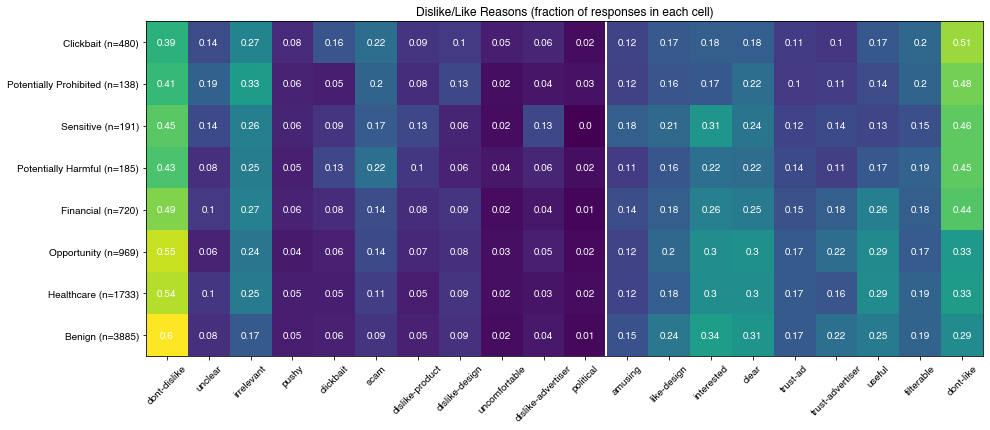

In [17]:
# note: this is essentially showing p(reason|code)
dislike_mat = []
like_mat = []
perceptions_mat = []
f, ax = plt.subplots(figsize=(15, 15))

# === plot the dislike matrix ===
plot_codes = []
benign_freqs = Counter(perceptions['Benign'])
plot_order = ['Clickbait', 'Potentially Prohibited', 'Sensitive', 'Potentially Harmful', 'Financial',
             'Opportunity', 'Healthcare', 'Benign']
for c in plot_order:
    if c in ['Political', "Can't determine, return to this one", "Study", "CA Lawsuit"]:
        continue
        
    plot_codes.append(f'{c} (n={survey_code_counts[c]})')
    freqs = Counter(perceptions[c])
    code_row = []
    # important to traverse in the same order -- dislike first, then like
    for reason in dislike_list + like_list:
        if reason in freqs:
            # ratio w.r.t benign
#             code_row.append((freqs[reason]/sum(freqs.values())) / (benign_freqs[reason]/sum(benign_freqs.values())))
            code_row.append(freqs[reason]/survey_code_counts[c])
        else:
            code_row.append(0)
    perceptions_mat.append(code_row)
    print(c, sum(code_row[:10]), sum(code_row[10:]))
    
perceptions_mat = np.array(perceptions_mat)
im = ax.imshow(perceptions_mat)
ax.set_yticks(np.arange(perceptions_mat.shape[0]), labels=plot_codes)
ax.set_xticks(np.arange(perceptions_mat.shape[1]), labels=dislike_list+like_list, rotation=45)
ax.set_title('Dislike/Like Reasons (fraction of responses in each cell)')
# ax.set_title('Dislike/Like Reasons -- (fraction of responses : fraction of responses for benign) in each cell')
for i in range(perceptions_mat.shape[0]):
    for j in range(perceptions_mat.shape[1]):
        text = ax.text(j, i, round(perceptions_mat[i, j], 2), ha="center", va="center", color="w", fontsize=10)
    
ax.axvline(len(dislike_list)-0.5, color='white', lw=2)
        
# plt.savefig('../figures/like-dislike-reasons-full.pdf', dpi=200, bbox_inches='tight')
# plt.savefig('like-dislike-ratio-benign.pdf', dpi=200, bbox_inches='tight')